In [16]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

# per importare cose nella folder precedente da ora in poi
import sys
sys.path.append('../')

from layer import HiddenLayer
from activations import *
from losses import *
from network import Network
from regularizers import *
from utils import *
from metrics import *
from validation import *
from gridsearch import grid_search

random.seed(42)
np.random.seed(42)

# Progress bar
from tqdm import tqdm
import time

In [3]:
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

### Separating training set and test set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

### Rescaling the output to the [0,1] range

In [5]:
np.random.seed(6)
net = Network(MSE(1), eta=5e-4, tau=250, cyclic=True) # we try the cyclic learning rate

net.add_layer(
    input_size=len(X_train[0]),
    units_size=512,
    activation=ReLU(),
    starting=Fan_in(low=-0.5, high=0.5),
    regularizer=L2(lambda_=1e-8),
    momentum=('Nesterov', 0.99)
)

net.add_layer(
    input_size=512,
    units_size=128,
    activation=ReLU(),
    starting=Fan_in(low=-0.5, high=0.5),
    regularizer=L2(lambda_=1e-8),
    momentum=('Nesterov', 0.99)
)

net.add_layer(
    input_size=128,
    units_size=3,
    activation=Identity(),
    starting=Fan_in(low=-0.5, high=0.5),
    regularizer=L2(lambda_=1e-8),
    momentum=('Nesterov', 0.99)
)

Epochs: 100%|██████████| 1000/1000 [09:49<00:00,  1.70it/s]


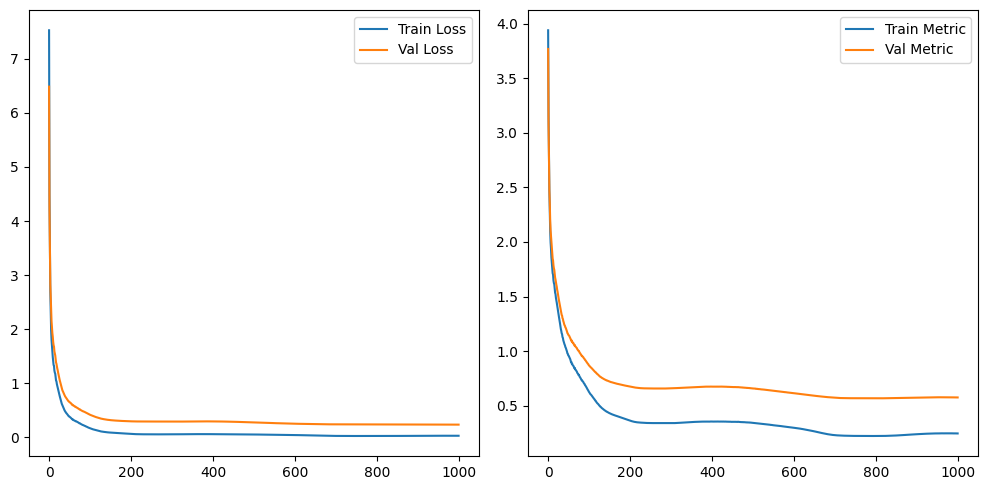

Fold 1 of 5 completed
Train Loss: 0.023039571424639135
Train Metric: 0.22540896315717257
Val Loss: 0.2345167899473349
Val Metric: 0.5687457427855384


Epochs: 100%|██████████| 1000/1000 [10:51<00:00,  1.53it/s]


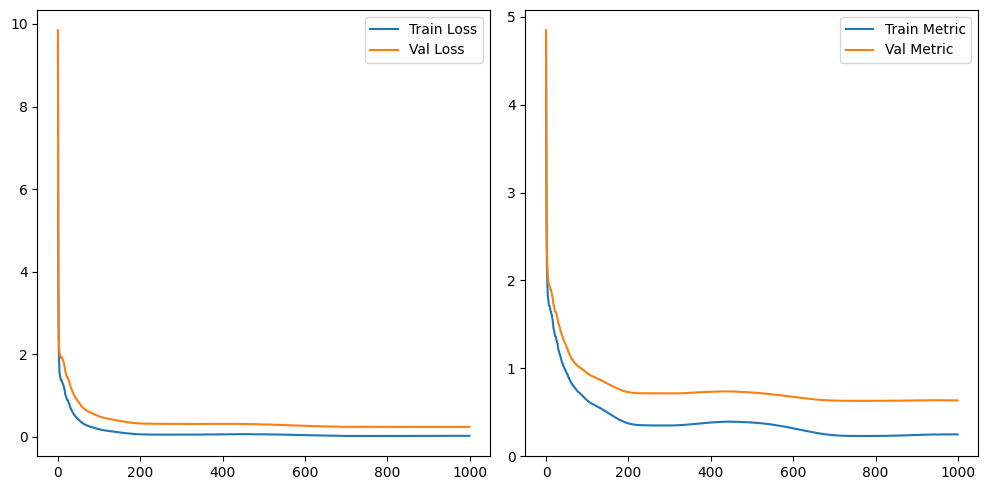

Fold 2 of 5 completed
Train Loss: 0.027531839449141005
Train Metric: 0.24861891996511468
Val Loss: 0.2436673471688066
Val Metric: 0.6362008193539858


Epochs: 100%|██████████| 1000/1000 [09:05<00:00,  1.83it/s]


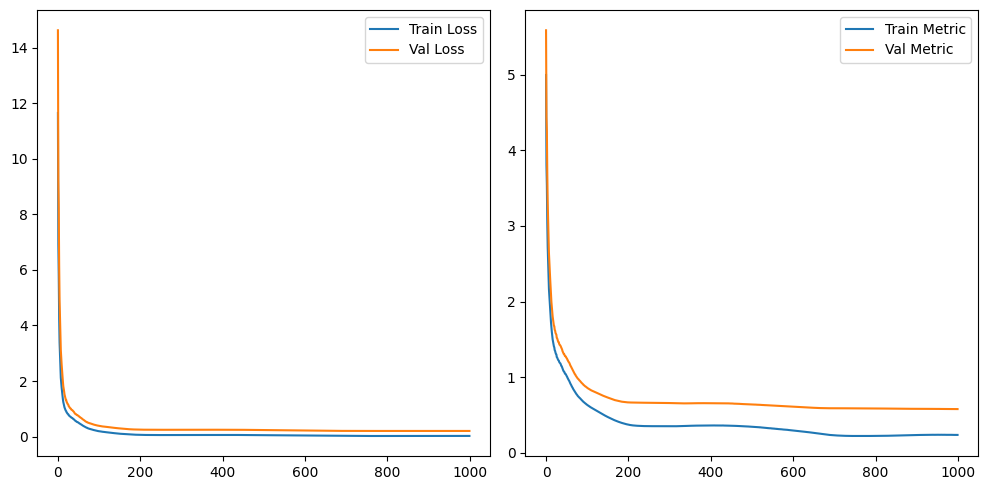

Fold 3 of 5 completed
Train Loss: 0.021664502813505526
Train Metric: 0.22259196379416207
Val Loss: 0.20321254447920586
Val Metric: 0.5867548146487411


Epochs: 100%|██████████| 1000/1000 [12:38<00:00,  1.32it/s]


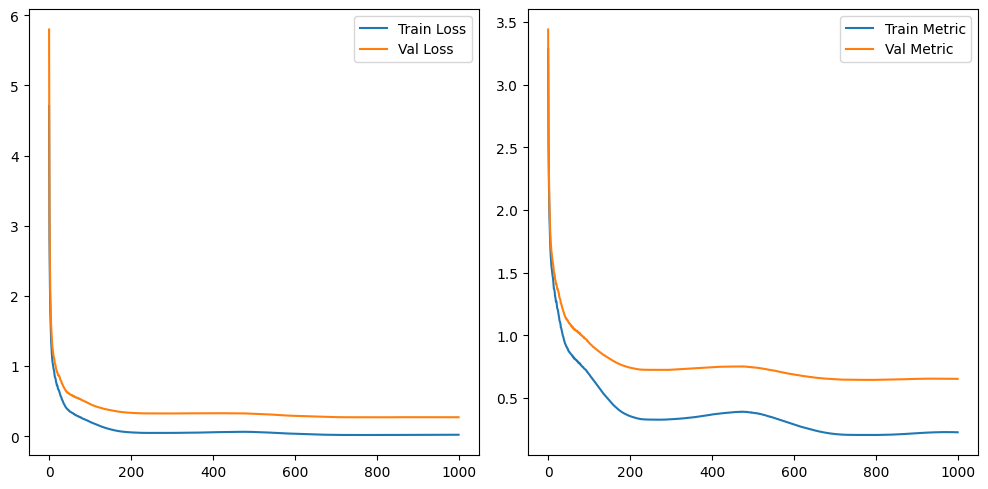

Fold 4 of 5 completed
Train Loss: 0.019026194548347204
Train Metric: 0.2093248069150408
Val Loss: 0.2717670063146836
Val Metric: 0.6478149804416569


Epochs: 100%|██████████| 1000/1000 [09:39<00:00,  1.72it/s]


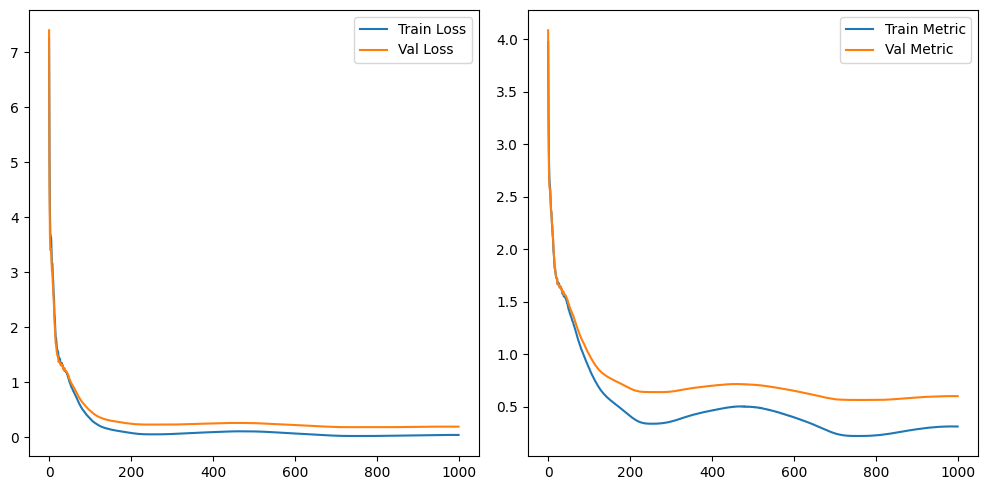

Fold 5 of 5 completed
Train Loss: 0.022820327813866136
Train Metric: 0.22894987284425464
Val Loss: 0.1813066698829715
Val Metric: 0.5668048329476987


In [6]:
data_to_csv = kfold_crossval(
    X=X_train,
    y=y_train,
    k=5,
    net=net,
    metric=MEE(),
    epochs=1000,
    patience=1000,
    verbose=True
)

In [7]:
data_to_csv

{'tr_loss': 0.022816487209899806,
 'tr_metric': 0.22697890533514897,
 'val_loss': 0.22689407155860047,
 'val_metric': 0.6012642380355242,
 'tr_loss_std': 0.0027560012542441658,
 'tr_metric_std': 0.012692928044073768,
 'val_loss_std': 0.031597641685103074,
 'val_metric_std': 0.034184683213774936}

In [8]:
import csv
layers_csv = []
net_csv = []
csv_file_path = '../statistics/test.csv'
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    net_csv.append(net.to_csv())
    writer.writerow(net_csv)
    for layer in net.layers:
        layers_csv.append(layer.to_csv())
    writer.writerow(layers_csv)
    # Write the data to the CSV file
    for row in data_to_csv:
        writer.writerow(row)

In [4]:
from sklearn.preprocessing import MinMaxScaler

rescaler = MinMaxScaler()
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
rescaler.fit(y_train)
y_train = rescaler.transform(y_train)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

Combination: [512, 128, 3] ReLU Fan_in (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.99) 0.0005


Epochs:  12%|█▏        | 1220/10000 [20:17<2:26:02,  1.00it/s]


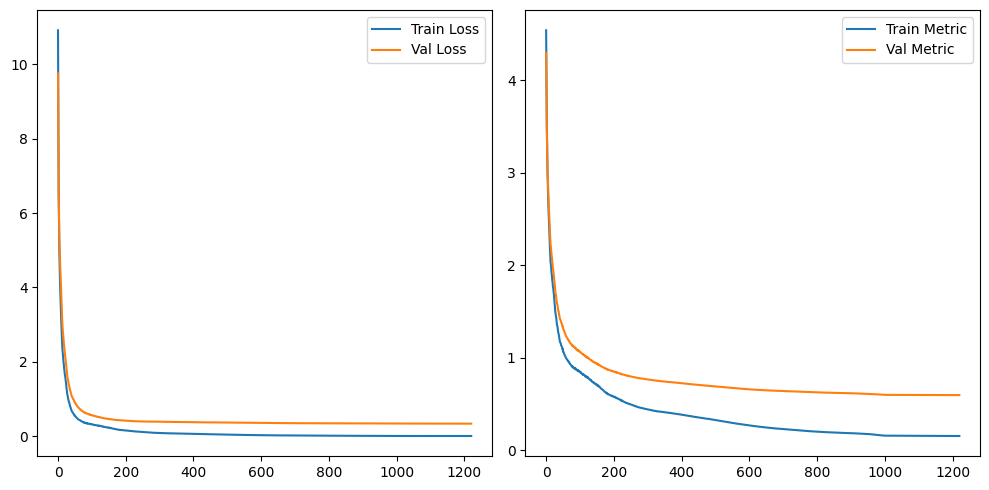

Fold 1 of 6 completed
Train Loss: 0.012404750233660614
Train Metric: 0.1666542774383869
Val Loss: 0.3455780271723378
Val Metric: 0.6038043881107539


Epochs:  12%|█▏        | 1182/10000 [21:50<2:42:56,  1.11s/it]


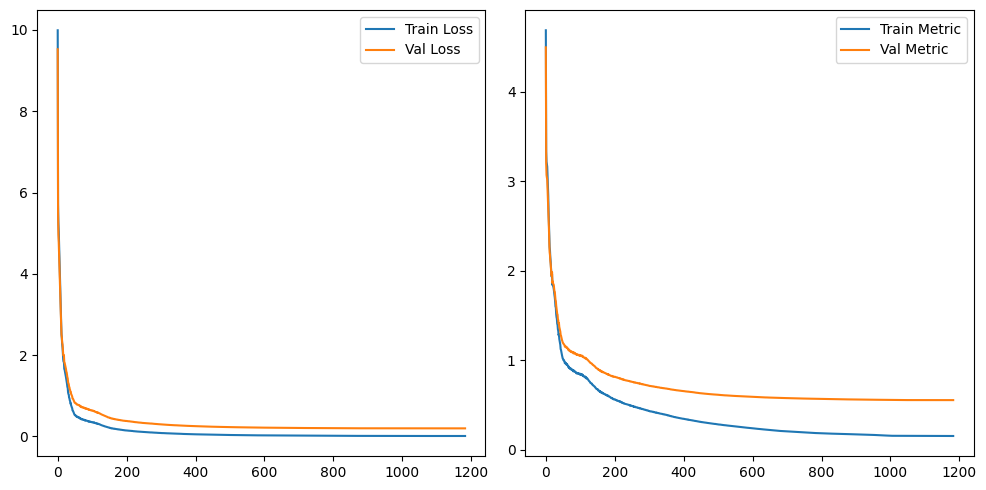

Fold 2 of 6 completed
Train Loss: 0.011428906504305846
Train Metric: 0.16559225574110822
Val Loss: 0.197899718304057
Val Metric: 0.5575791589446398


Epochs:  12%|█▏        | 1206/10000 [17:56<2:10:46,  1.12it/s]


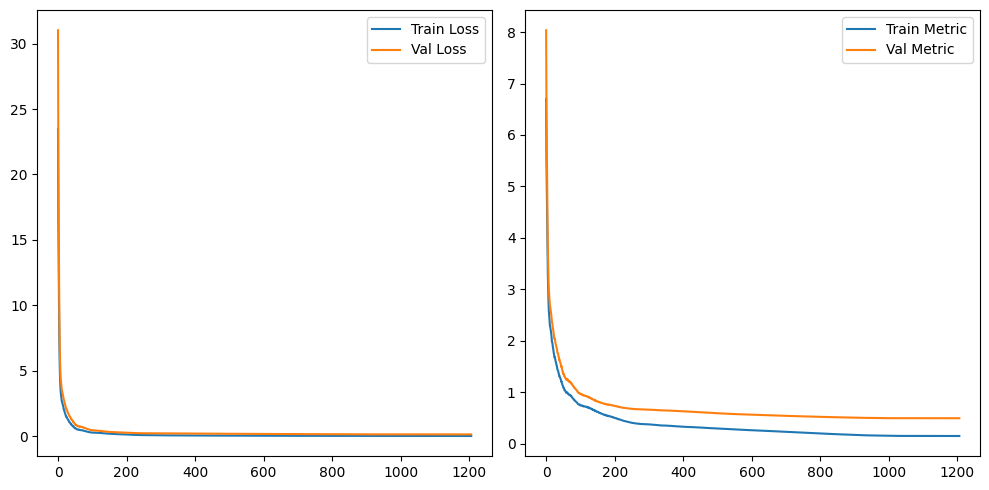

Fold 3 of 6 completed
Train Loss: 0.010296485895366168
Train Metric: 0.15661732692964428
Val Loss: 0.13397908255638746
Val Metric: 0.49665142412016516


Epochs:  12%|█▏        | 1155/10000 [18:52<2:24:32,  1.02it/s]


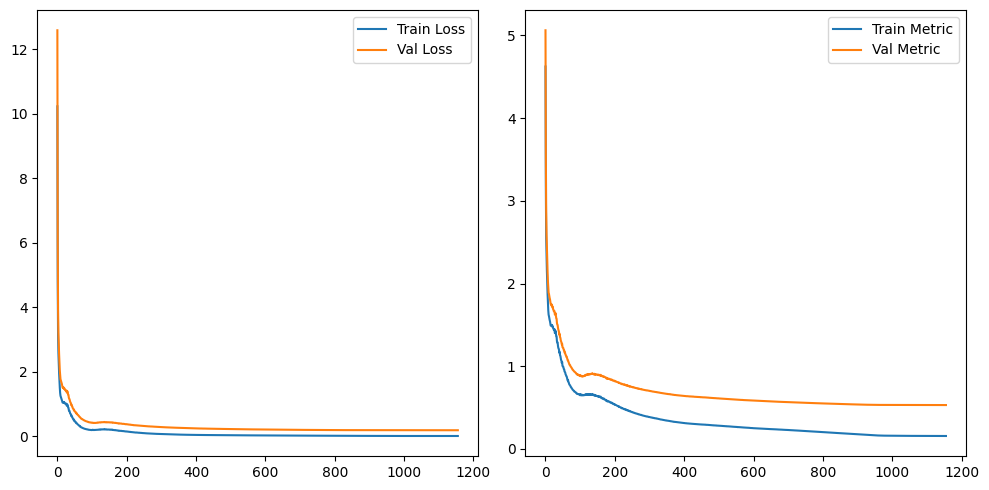

Fold 4 of 6 completed
Train Loss: 0.01306411965934931
Train Metric: 0.1742559099098867
Val Loss: 0.18914176754821566
Val Metric: 0.5358061661633935


Epochs:  12%|█▏        | 1151/10000 [17:41<2:16:03,  1.08it/s]


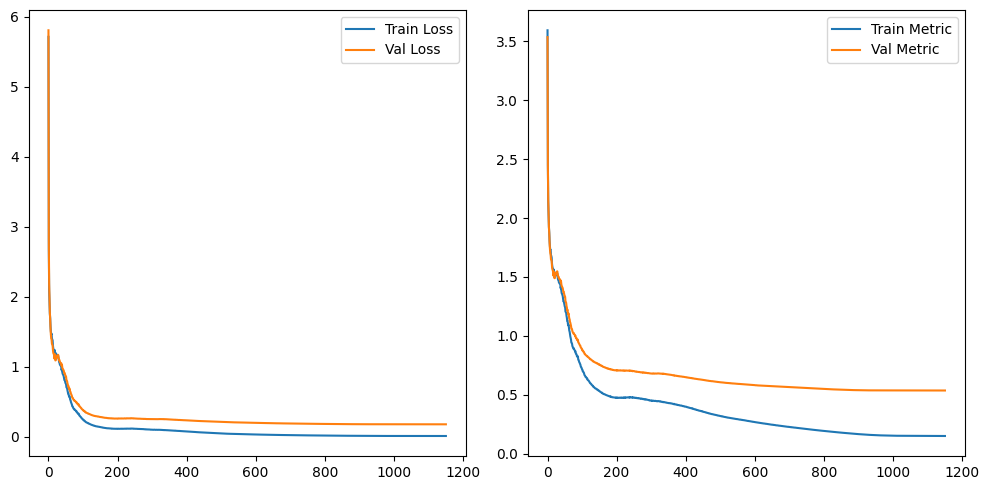

Fold 5 of 6 completed
Train Loss: 0.011927843756832281
Train Metric: 0.16579998703468135
Val Loss: 0.17808956953194624
Val Metric: 0.5385412826824073


Epochs:  12%|█▏        | 1232/10000 [22:03<2:37:00,  1.07s/it]


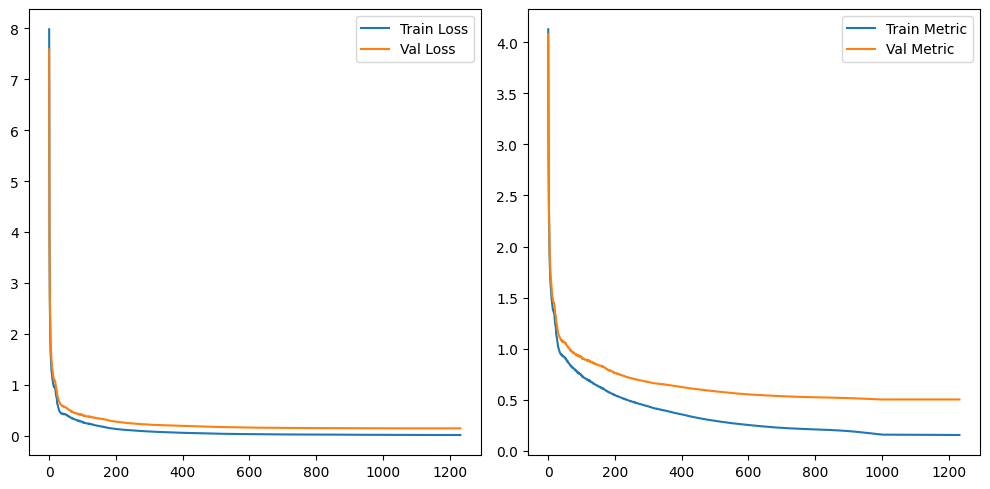

Fold 6 of 6 completed
Train Loss: 0.012138181515511357
Train Metric: 0.16712743393734744
Val Loss: 0.1411872365208041
Val Metric: 0.506309152679626
Combination: [512, 128, 3] ReLU Fan_in (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.99) 0.0005
Statistics: {'tr_loss': 0.01187671459417093, 'tr_metric': 0.16600786516517582, 'val_loss': 0.19764590027229137, 'val_metric': 0.5397819287834976}


In [4]:
hyperparameters = {
    'layers_sizes': [[512, 128, 3]],
    'activations': ["ReLU"], 
    'startings': ["Fan_in"],
    'startings_range': [(-0.5, 0.5)],
    'regularizers': ["L2"],
    'regularizers_lambda': [1e-8],
    'momentums': [('Nesterov', 0.99)],
    'etas': [5e-4],
}

data_to_csv = grid_search(
    hyperparams=hyperparameters,
    X=X_train,
    y=y_train,
    k=6,
    metric=MEE(),
    loss=MSE(1),
    seed=6,
    verbose=True
)

In [ ]:
# reshape ytrain eliminating last shape
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
y_train.shape

In [ ]:
# reshape Xtrain eliminating last shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_train.shape

In [ ]:
# use scikit-lear to make regression in 3d
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(32,32),
    activation='relu',
    solver='sgd',
    alpha=0,
    batch_size=1,
    learning_rate_init=1e-3,
    max_iter=2500,
    shuffle=True,
    random_state=6,
    verbose=True,
    momentum=0,
    beta_1= 0,
    beta_2= 0.,
    epsilon= 1,
    validation_fraction = 0,
    nesterovs_momentum=False
)

mlp.fit(X_train, y_train)
# print the learning curve
plt.plot(mlp.loss_curve_)
plt.show()

# print the mean error
print(MEE()(y_train, mlp.predict(X_train)))

In [9]:
import csv

csv_file_path = '../statistics/test.csv'
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    # Write the data to the CSV file
    for row in data_to_csv:
        writer.writerow(row)    

# Second step of the gridsearch
 initializing weights around the best ones found in the first step ...
 or maybe put regularization just on the last layer ...
 or maybe changing the momentum ...
 but the structure of the net is the same

# Let's test in the test set! (NOT the blind one)
- k-fold cv (train and val set) gridsearch --> in the cells above
- train the best model on the whole training set
- test on the test set

In [6]:
# Set the hyperparameters of the model than won the gridsearch
np.random.seed(6)

best_net = Network(MSE(1), eta=5e-4)

best_net.add_layer(
    input_size=len(X_train[0]),
    units_size=64,
    starting=Fan_in(),
    activation=ReLU(),
    regularizer=L2(lambda_=1e-8),
    momentum=('Nesterov', 0.9)
)

best_net.add_layer(
    input_size=64,
    units_size=64,
    starting=Fan_in(),
    activation=ReLU(),
    regularizer=L2(lambda_=1e-8),
    momentum=('Nesterov', 0.9)
)

best_net.add_layer(
    input_size=64,
    units_size=3,
    starting=Fan_in(),
    activation=Identity(),
    regularizer=L2(lambda_=1e-8),
    momentum=('Nesterov', 0.9)
)

We have the bet net, let's train it on the whole training set. BUT when should we stop? We try 2 things:
- early stopping using the whole training set as validation set
- max number of epochs that were necessary to the best model in the k-fold cv

1. Let's train the best model on the whole training set using early stopping monitoring the whole training set 

In [7]:
info = best_net.train(
    X_train, 
    y_train,
    X_train, 
    y_train,
    epochs=10000, 
    metric=MEE(),
    patience=250
)

Epochs:  13%|█▎        | 1321/10000 [00:54<05:55, 24.39it/s]


Train Loss:  0.04281344759554002
Train Metric:  0.31974251210759597


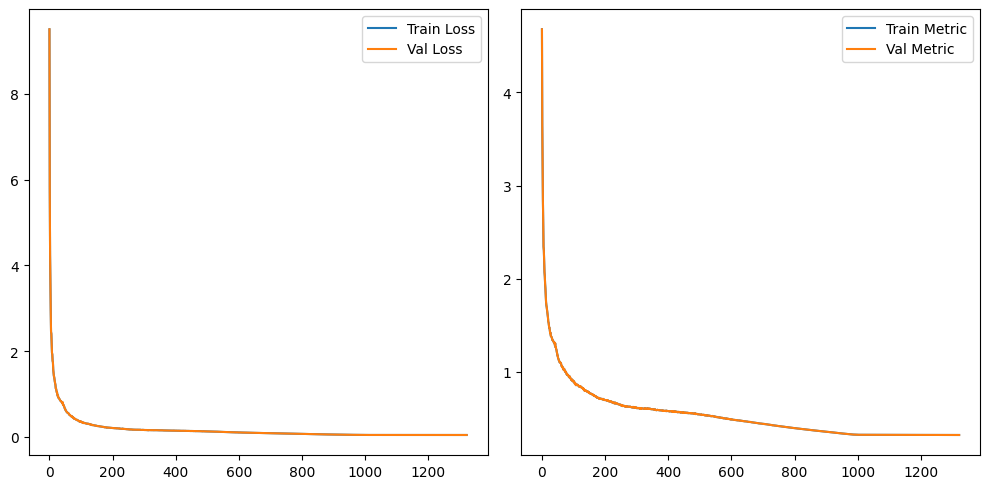

In [11]:
# Let's print the last value of the loss and metric on the training set (= val set)
print("Train Loss: ", info['tr_losses'][-1])
print("Train Metric: ", info['tr_metrics'][-1])

# Let's plot the train (and val) loss and metric
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(info['tr_losses'], label='Train Loss')
plt.plot(info['val_losses'], label='Val Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(info['tr_metrics'], label='Train Metric')
plt.plot(info['val_metrics'], label='Val Metric')
plt.legend()


plt.tight_layout()
plt.show()

In [19]:
# Let's see the output of the best model on the test set
y_pred = np.zeros((X_test.shape[0], 3, 1))

for i in range(X_test.shape[0]):
    y_pred[i] = best_net.forward(X_test[i])

# Let's print the metric on the test set
print("Test Metric: ", MEE()(y_test, y_pred))

Test Metric:  0.6606804179384909


2. Let's train the best model on the whole training set using the max number of epochs that were necessary to the best model in the k-fold cv

In [27]:
# !!! RESET THE BEST NET !!!
np.random.seed(6)

best_net = Network(MSE(1), eta=5e-4)

best_net.add_layer(
    input_size=len(X_train[0]),
    units_size=64,
    starting=Fan_in(),
    activation=ReLU(),
    regularizer=L2(lambda_=1e-8),
    momentum=('Nesterov', 0.9)
)

best_net.add_layer(
    input_size=64,
    units_size=64,
    starting=Fan_in(),
    activation=ReLU(),
    regularizer=L2(lambda_=1e-8),
    momentum=('Nesterov', 0.9)
)

best_net.add_layer(
    input_size=64,
    units_size=3,
    starting=Fan_in(),
    activation=Identity(),
    regularizer=L2(lambda_=1e-8),
    momentum=('Nesterov', 0.9)
)

In [28]:
info = best_net.train(
    X_train, 
    y_train,
    X_train, 
    y_train,
    epochs=1465, 
    patience=1465, # so it won't be used
    metric=MEE()
)

Epochs: 100%|██████████| 1465/1465 [01:00<00:00, 24.25it/s]


Train Loss:  0.042650402066250696
Train Metric:  0.3191501614790996


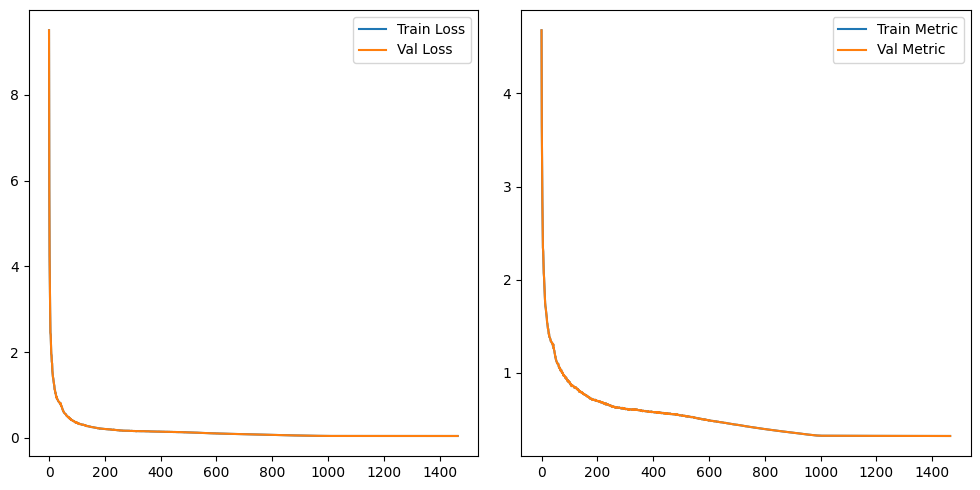

In [29]:
# Let's print the last value of the loss and metric on the training set (= val set)
print("Train Loss: ", info['tr_losses'][-1])
print("Train Metric: ", info['tr_metrics'][-1])

# Let's plot the train (and val) loss and metric
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(info['tr_losses'], label='Train Loss')
plt.plot(info['val_losses'], label='Val Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(info['tr_metrics'], label='Train Metric')
plt.plot(info['val_metrics'], label='Val Metric')
plt.legend()


plt.tight_layout()
plt.show()

In [30]:
# Let's see the output of the best model on the test set
y_pred = np.zeros((X_test.shape[0], 3, 1))

for i in range(X_test.shape[0]):
    y_pred[i] = best_net.forward(X_test[i])

# Let's print the metric on the test set
print("Test Metric: ", MEE()(y_test, y_pred))

Test Metric:  0.6569128436757649


... but if we go on and on and on ...

In [47]:
info = best_net.train(
    X_train, 
    y_train,
    X_train, 
    y_train,
    epochs=1000, 
    patience=1000, # so it won't be used
    metric=MEE()
)

Epochs: 100%|██████████| 1000/1000 [00:42<00:00, 23.73it/s]


Train Loss:  0.011296812263675914
Train Metric:  0.1654674515068227


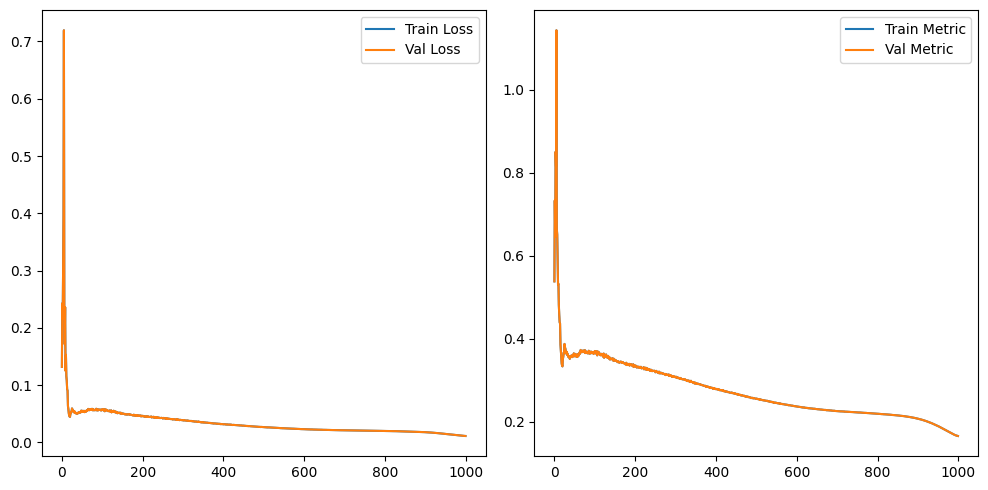

In [48]:
# Let's print the last value of the loss and metric on the training set (= val set)
print("Train Loss: ", info['tr_losses'][-1])
print("Train Metric: ", info['tr_metrics'][-1])

# Let's plot the train (and val) loss and metric
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(info['tr_losses'], label='Train Loss')
plt.plot(info['val_losses'], label='Val Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(info['tr_metrics'], label='Train Metric')
plt.plot(info['val_metrics'], label='Val Metric')
plt.legend()


plt.tight_layout()
plt.show()

In [49]:
# Let's see the output of the best model on the test set
y_pred = np.zeros((X_test.shape[0], 3, 1))

for i in range(X_test.shape[0]):
    y_pred[i] = best_net.forward(X_test[i])

# Let's print the metric on the test set
print("Test Metric: ", MEE()(y_test, y_pred))

Test Metric:  0.544866073729173


In [ ]:
0.5378314730327738

In [7]:
plot = []
step = 0
tau = 1000
eta = 5e-4
eta_tau = eta * 0.01
for i in range (5000):
    step = i % 1000
    if step  > tau:
            step = tau
    #step = i % 250
    alpha = step / tau
    eta_step = (1 - alpha) * eta + alpha * eta_tau
    plot.append(eta_step)

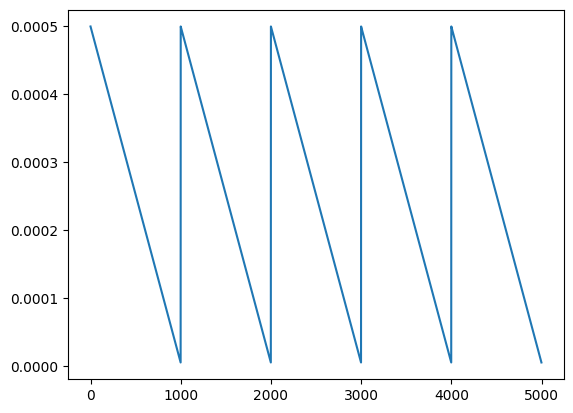

In [8]:
import matplotlib.pyplot as plt
plt.plot(plot)
plt.show()

In [94]:
plot = []
step = 0
cycle = 1000
eta = 5e-4
eta_tau = eta * 0.01
n_cycles = 0
for i in range (5000):
    if (i+1) % cycle == 0:
        n_cycles += 1
    step = (i+1) % cycle
    #step = i % 250
    alpha = step / cycle
    #eta_step = (1 - alpha) * eta + alpha * eta_tau
    eta_step = eta_tau + 0.5 * (eta/2**n_cycles - eta_tau) * (1 + np.cos(np.pi * step / cycle))
    plot.append(eta_step)

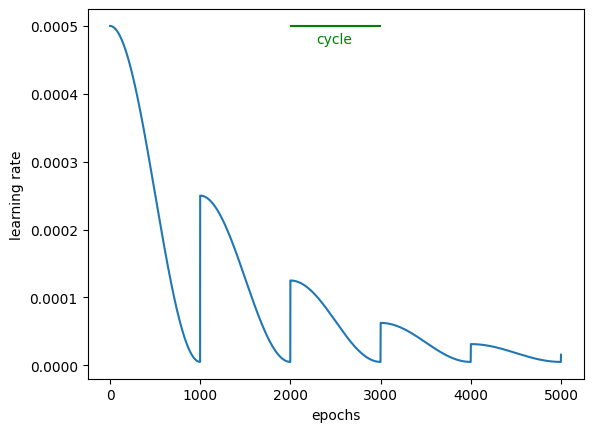

In [95]:
import matplotlib.pyplot as plt
plt.plot(plot)
# add x and y labels
plt.xlabel('epochs')
plt.ylabel('learning rate')
# add horizontal segment from 2000 to 3000 with a written: cycle
plt.axhline(y=0.0005, xmin=0.41, xmax=0.59, color='g')
plt.text(2290, 0.000475, 'cycle', color='g', fontsize=10)
plt.show()

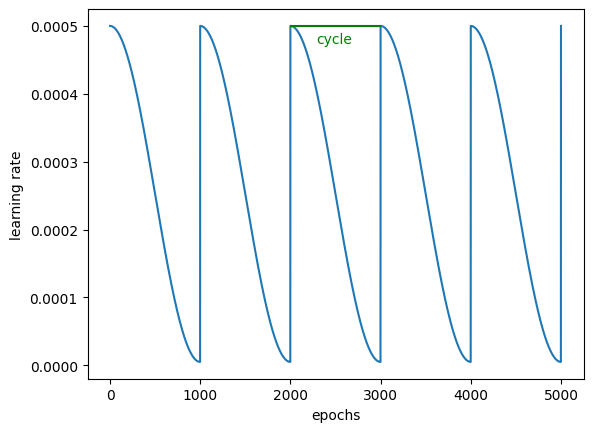

In [96]:
plot = []
step = 0
cycle = 1000
eta = 5e-4
eta_tau = eta * 0.01
n_cycles = 0
for i in range (5000):
    if (i+1) % cycle == 0:
        n_cycles += 1
    step = (i+1) % cycle
    #step = i % 250
    alpha = step / cycle
    #eta_step = (1 - alpha) * eta + alpha * eta_tau
    eta_step = eta_tau + 0.5 * (eta - eta_tau) * (1 + np.cos(np.pi * step / cycle))
    plot.append(eta_step)

plt.plot(plot)
# add x and y labels
plt.xlabel('epochs')
plt.ylabel('learning rate')
# add horizontal segment from 2000 to 3000 with a written: cycle
plt.axhline(y=0.0005, xmin=0.41, xmax=0.59, color='g')
plt.text(2290, 0.000475, 'cycle', color='g', fontsize=10)
plt.show()

In [17]:
# show max and min in the previous plot
print(max(plot))
print(min(plot))
print(eta)
print(eta_tau)

0.0005
5.000064769225612e-06
0.0005
5e-06


In [88]:
plot = []
step = 0
cycle = 500
eta = 5e-4
eta_tau = eta * 0.01
n_cycles = 1
for i in range (4500):
    if (i+1) % cycle == 0:
        n_cycles *= -1
    step = (i+1) % cycle
    eta_step = eta_tau + 0.5 * (eta - eta_tau) * (1 + np.cos(np.pi * step / cycle)) * n_cycles 
    if n_cycles == -1:
        eta_step = eta_step + eta - eta_tau
    plot.append(eta_step)

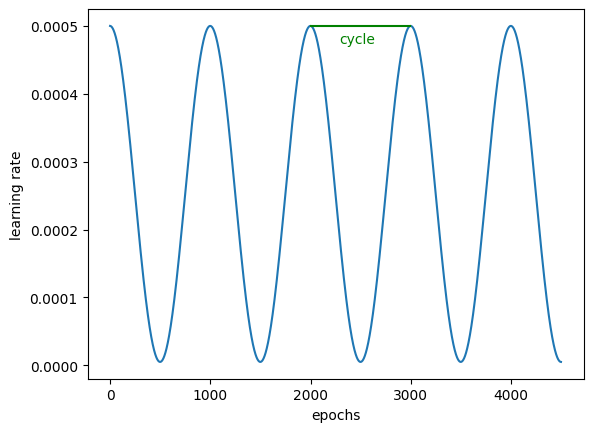

In [93]:
import matplotlib.pyplot as plt
plt.plot(plot)
# add x and y labels
plt.xlabel('epochs')
plt.ylabel('learning rate')
# add horizontal segment from 2000 to 3000 with a written: cycle
plt.axhline(y=0.0005, xmin=0.45, xmax=0.65, color='g')
plt.text(2290, 0.000475, 'cycle', color='g', fontsize=10)
plt.show()

In [45]:
print(max(plot))
print(min(plot))

0.0005
5.000000000000026e-06


In [97]:
plot = []
step = 0
cycle = 500
eta = 5e-4
eta_tau = eta * 0.01
n_cycles = 1
cycles = 0
for i in range (4500):
    if (i+1) % cycle == 0:
        n_cycles *= -1
        if n_cycles == -1:
            cycles += 1
    step = (i+1) % cycle
    eta_step = eta_tau + 0.5 * (eta/2**cycles - eta_tau) * (1 + np.cos(np.pi * step / cycle)) * n_cycles 
    if n_cycles == -1:
        eta_step = eta_step + eta/2**cycles - eta_tau
    plot.append(eta_step)

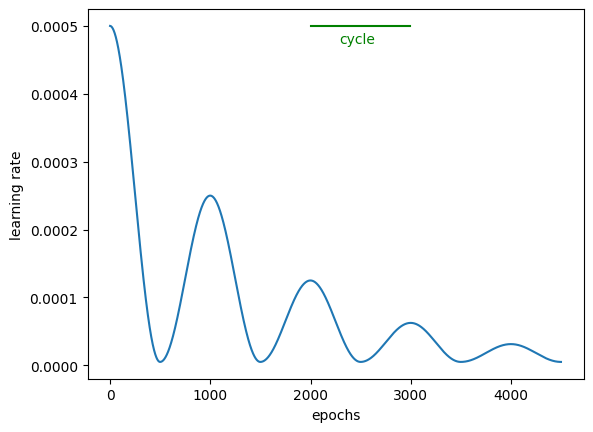

In [98]:
import matplotlib.pyplot as plt
plt.plot(plot)
# add x and y labels
plt.xlabel('epochs')
plt.ylabel('learning rate')
# add horizontal segment from 2000 to 3000 with a written: cycle
plt.axhline(y=0.0005, xmin=0.45, xmax=0.65, color='g')
plt.text(2290, 0.000475, 'cycle', color='g', fontsize=10)
plt.show()

In [72]:
print(max(plot), min(plot))

0.0004999951145618939 4.999999999999999e-06


We try the cyclic learning rate